In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
from scipy import stats as ss

num_cols = train.select_dtypes(include=np.number).columns.tolist()
cat_cols = train.select_dtypes(include='object').columns.tolist()
# Pearson correlation for numerical columns
pearson_corr = train[num_cols].corr()

# Function to calculate Cramer's V correlation
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Create Cramer's V correlation matrix for categorical columns
# Filter out columns with too many unique values or only one value
cat_cols_filtered = []
for col in cat_cols:
    if 1 < train[col].nunique() < 30:
        cat_cols_filtered.append(col)

cramer_v_corr = pd.DataFrame(index=cat_cols_filtered, columns=cat_cols_filtered)
for i in cat_cols_filtered:
    for j in cat_cols_filtered:
        if i == j:
            cramer_v_corr.loc[i, j] = 1.0
        else:
            try:
                # Handle missing values by dropping them
                idx = train[[i, j]].dropna().index
                if len(idx) > 0:
                    cramer_v_corr.loc[i, j] = cramers_v(train.loc[idx, i], train.loc[idx, j])
                else:
                    cramer_v_corr.loc[i, j] = np.nan
            except Exception as e:
                print(f"Error calculating Cramer's V for {i} and {j}: {e}")
                cramer_v_corr.loc[i, j] = np.nan

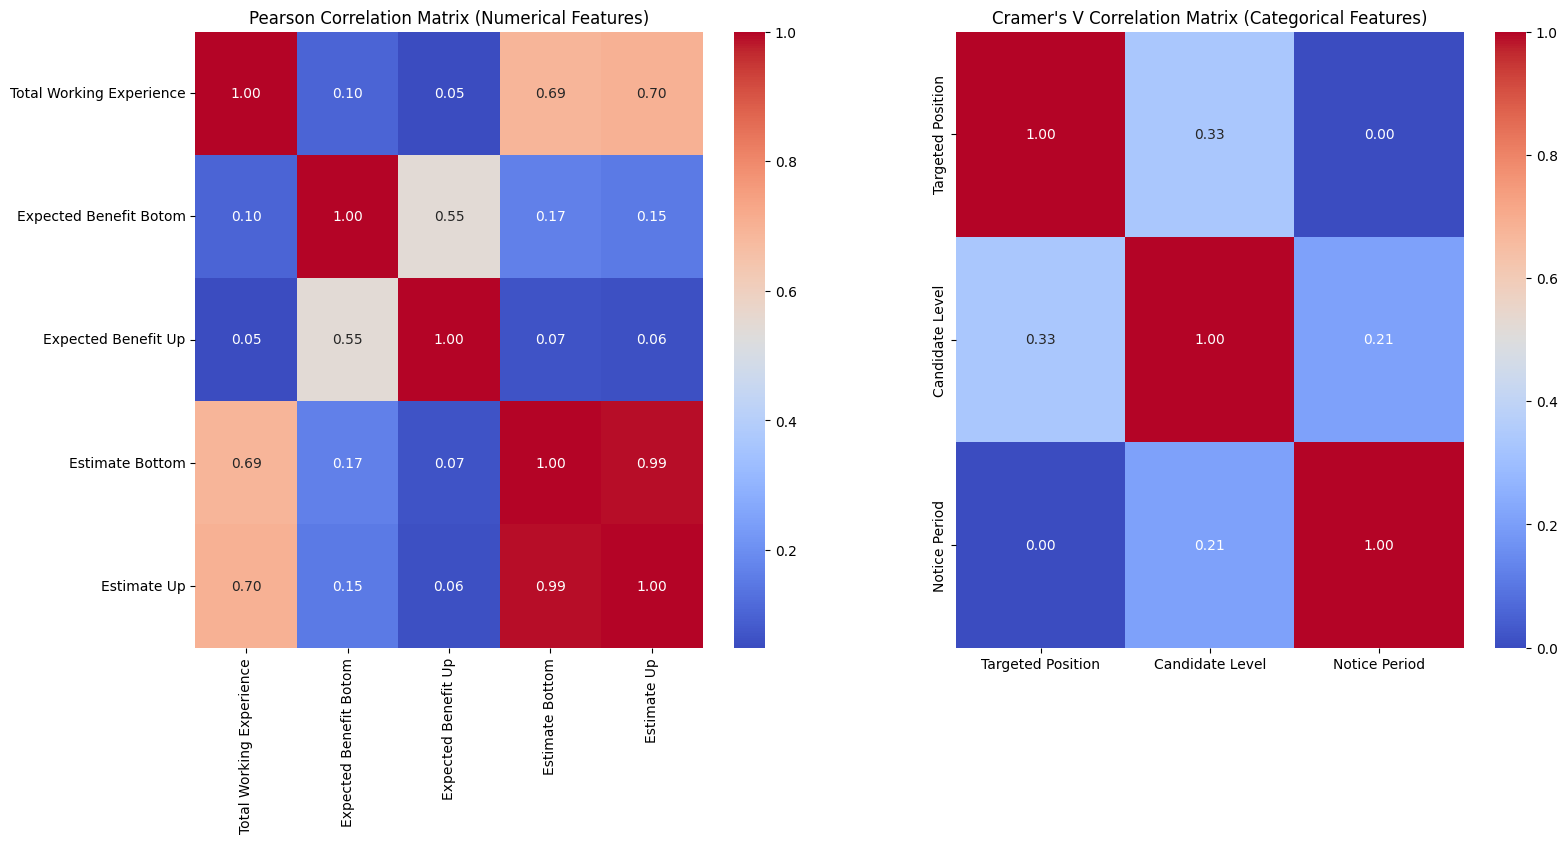

In [18]:
for i in cat_cols_filtered:
    for j in cat_cols_filtered:
        if i == j:
            cramer_v_corr.loc[i, j] = 1.0
        else:
            try:
                # Handle missing values by dropping them
                idx = train[[i, j]].dropna().index
                if len(idx) > 0:
                    result = cramers_v(train.loc[idx, i], train.loc[idx, j])
                    # Ensure the result is numeric
                    cramer_v_corr.loc[i, j] = float(result) if pd.notna(result) else np.nan
                else:
                    cramer_v_corr.loc[i, j] = np.nan
            except Exception as e:
                print(f"Error calculating Cramer's V for {i} and {j}: {e}")
                cramer_v_corr.loc[i, j] = np.nan

# Convert to numeric and handle any remaining object types
cramer_v_corr = pd.to_numeric(cramer_v_corr.stack(), errors='coerce').unstack()

# Visualize the correlations
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# For Pearson correlation
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix (Numerical Features)')

# For Cramer's V with additional error checking
try:
    sns.heatmap(cramer_v_corr, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
    axes[1].set_title('Cramer\'s V Correlation Matrix (Categorical Features)')
except Exception as e:
    print(f"Error creating Cramer's V heatmap: {e}")
    print(f"Data types in cramer_v_corr:\n{cramer_v_corr.dtypes}")
    print(f"Sample values:\n{cramer_v_corr.head()}")

In [19]:
print("Dataset shape:", train.shape)
print("\nColumn names:")
print(train.columns.tolist())
print("\nFirst few rows:")
print(train.head())
print("\nCategorical columns:")
print(cat_cols)
print("\nNumerical columns:")
print(num_cols)

Dataset shape: (1160, 16)

Column names:
['ID', 'Current Position', 'Targeted Position', 'Total Working Experience', 'Candidate Level', 'Domisili', 'Education 1', 'Education 2', 'Education 3', 'Expected Benefit Botom', 'Expected Benefit Up', 'Notice Period', 'Tech Stack', 'Certification', 'Estimate Bottom', 'Estimate Up']

First few rows:
             ID      Current Position Targeted Position  \
0  SKU-WENU1319         Web Developer               NaN   
1  SKU-FUNU1303  Full Stack Developer               NaN   
2  SKU-JUNU1052  Junior Web Developer               NaN   
3   SKU-JANU420        Java Developer               NaN   
4  SKU-NUNU1182                   NaN               NaN   

   Total Working Experience Candidate Level               Domisili  \
0                         2          Junior                Bandung   
1                         1       Mid-Level                Bandung   
2                         0          Junior  Semarang, Jawa Tengah   
3                       

In [20]:
# Calculate Cramer's V correlation between categorical features and target variables
# First, we need to bin the target variables into categories since Cramer's V works with categorical data

# Remove ID column from categorical analysis as it's just an identifier
cat_cols_for_analysis = [col for col in cat_cols if col != 'ID']

# Create binned versions of target variables
def create_salary_bins(salary_column, n_bins=5):
    """Create categorical bins for salary data"""
    clean_data = salary_column.dropna()
    try:
        # Try qcut first
        return pd.qcut(clean_data, q=n_bins, duplicates='drop')
    except ValueError:
        # If qcut fails due to duplicates, use cut instead
        return pd.cut(clean_data, bins=n_bins)

# Bin the target variables
train['Estimate_Bottom_Binned'] = None
train['Estimate_Up_Binned'] = None

# Create binned versions for non-null values
bottom_mask = train['Estimate Bottom'].notna()
up_mask = train['Estimate Up'].notna()

if bottom_mask.sum() > 0:
    train.loc[bottom_mask, 'Estimate_Bottom_Binned'] = create_salary_bins(train.loc[bottom_mask, 'Estimate Bottom'])
if up_mask.sum() > 0:
    train.loc[up_mask, 'Estimate_Up_Binned'] = create_salary_bins(train.loc[up_mask, 'Estimate Up'])

print("Binned target distributions:")
print("\nEstimate Bottom Binned:")
print(train['Estimate_Bottom_Binned'].value_counts().sort_index())
print("\nEstimate Up Binned:")
print(train['Estimate_Up_Binned'].value_counts().sort_index())

# Calculate Cramer's V for each categorical feature with both target variables
target_correlations = pd.DataFrame(index=cat_cols_for_analysis, 
                                 columns=['Cramer_V_Bottom', 'Cramer_V_Up'])

for cat_col in cat_cols_for_analysis:
    # Skip columns with too many unique values or missing data
    if train[cat_col].nunique() > 50 or train[cat_col].isna().sum() > len(train) * 0.5:
        target_correlations.loc[cat_col, 'Cramer_V_Bottom'] = np.nan
        target_correlations.loc[cat_col, 'Cramer_V_Up'] = np.nan
        continue
    
    # Calculate Cramer's V for Estimate Bottom
    try:
        valid_idx_bottom = train[[cat_col, 'Estimate_Bottom_Binned']].dropna().index
        if len(valid_idx_bottom) > 10:  # Need sufficient data
            cramer_bottom = cramers_v(train.loc[valid_idx_bottom, cat_col], 
                                    train.loc[valid_idx_bottom, 'Estimate_Bottom_Binned'])
            target_correlations.loc[cat_col, 'Cramer_V_Bottom'] = cramer_bottom
        else:
            target_correlations.loc[cat_col, 'Cramer_V_Bottom'] = np.nan
    except Exception as e:
        print(f"Error calculating Cramer's V for {cat_col} vs Bottom: {e}")
        target_correlations.loc[cat_col, 'Cramer_V_Bottom'] = np.nan
    
    # Calculate Cramer's V for Estimate Up
    try:
        valid_idx_up = train[[cat_col, 'Estimate_Up_Binned']].dropna().index
        if len(valid_idx_up) > 10:  # Need sufficient data
            cramer_up = cramers_v(train.loc[valid_idx_up, cat_col], 
                                train.loc[valid_idx_up, 'Estimate_Up_Binned'])
            target_correlations.loc[cat_col, 'Cramer_V_Up'] = cramer_up
        else:
            target_correlations.loc[cat_col, 'Cramer_V_Up'] = np.nan
    except Exception as e:
        print(f"Error calculating Cramer's V for {cat_col} vs Up: {e}")
        target_correlations.loc[cat_col, 'Cramer_V_Up'] = np.nan

# Convert to numeric and sort by importance
target_correlations = target_correlations.astype(float)
target_correlations['Average_Cramer_V'] = target_correlations[['Cramer_V_Bottom', 'Cramer_V_Up']].mean(axis=1)
target_correlations_sorted = target_correlations.sort_values('Average_Cramer_V', ascending=False)

print("\n" + "="*60)
print("CRAMER'S V CORRELATION WITH TARGET VARIABLES")
print("="*60)
print(target_correlations_sorted.round(4))

# Identify most important features
print("\n" + "="*60)
print("TOP PREDICTIVE CATEGORICAL FEATURES")
print("="*60)
top_features = target_correlations_sorted.dropna().head(5)
for i, (feature, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i}. {feature}:")
    print(f"   - Cramer's V with Bottom: {row['Cramer_V_Bottom']:.4f}")
    print(f"   - Cramer's V with Up: {row['Cramer_V_Up']:.4f}")
    print(f"   - Average: {row['Average_Cramer_V']:.4f}")
    print()

Binned target distributions:

Estimate Bottom Binned:
Estimate_Bottom_Binned
(2499999.999, 4000000.0]    256
(4000000.0, 7000000.0]      221
(7000000.0, 8000000.0]      506
(8000000.0, 35000000.0]     177
Name: count, dtype: int64

Estimate Up Binned:
Estimate_Up_Binned
(3999999.999, 7000000.0]    260
(7000000.0, 11000000.0]     211
(11000000.0, 12000000.0]    428
(12000000.0, 14000000.0]     75
(14000000.0, 55000000.0]    186
Name: count, dtype: int64

CRAMER'S V CORRELATION WITH TARGET VARIABLES
                   Cramer_V_Bottom  Cramer_V_Up  Average_Cramer_V
Candidate Level             0.5917       0.5134            0.5525
Current Position               NaN          NaN               NaN
Targeted Position              NaN          NaN               NaN
Domisili                       NaN          NaN               NaN
Education 1                    NaN          NaN               NaN
Education 2                    NaN          NaN               NaN
Education 3                    NaN 

In [21]:
# More detailed analysis - let's examine each categorical feature
print("\n" + "="*80)
print("DETAILED ANALYSIS OF CATEGORICAL FEATURES")
print("="*80)

# Analyze each categorical feature individually
for col in cat_cols_for_analysis:
    print(f"\n{col.upper()}:")
    print(f"  Unique values: {train[col].nunique()}")
    print(f"  Missing values: {train[col].isna().sum()}")
    print(f"  Missing percentage: {train[col].isna().sum()/len(train)*100:.1f}%")
    
    if train[col].nunique() <= 20:  # Show value counts for manageable number of categories
        print(f"  Value counts:\n{train[col].value_counts().head(10)}")

# Let's create simplified versions of high-cardinality features
print("\n" + "="*80)
print("PROCESSING HIGH-CARDINALITY FEATURES")
print("="*80)

# Process features that have too many categories
processed_features = {}

# Domisili - extract main city/region
if 'Domisili' in train.columns:
    train['Domisili_Simple'] = train['Domisili'].fillna('Unknown')
    # Extract main cities
    main_cities = ['Jakarta', 'Bandung', 'Surabaya', 'Yogyakarta', 'Semarang', 'Medan']
    train['Domisili_Grouped'] = train['Domisili_Simple'].apply(
        lambda x: next((city for city in main_cities if city in str(x)), 'Other')
    )
    processed_features['Domisili_Grouped'] = 'Domisili_Grouped'
    print(f"Domisili grouped into: {train['Domisili_Grouped'].value_counts()}")

# Current Position - group similar positions
if 'Current Position' in train.columns:
    train['Position_Clean'] = train['Current Position'].fillna('No Position')
    # Group similar positions
    def categorize_position(pos):
        if pd.isna(pos) or pos == 'No Position':
            return 'No Position'
        pos_lower = str(pos).lower()
        if any(word in pos_lower for word in ['senior', 'sr', 'lead']):
            return 'Senior Level'
        elif any(word in pos_lower for word in ['junior', 'jr']):
            return 'Junior Level'
        elif any(word in pos_lower for word in ['web', 'frontend', 'front-end']):
            return 'Web Developer'
        elif any(word in pos_lower for word in ['fullstack', 'full stack', 'full-stack']):
            return 'Full Stack Developer'
        elif any(word in pos_lower for word in ['backend', 'back-end']):
            return 'Backend Developer'
        elif any(word in pos_lower for word in ['mobile', 'android', 'ios']):
            return 'Mobile Developer'
        elif any(word in pos_lower for word in ['data', 'analyst', 'science']):
            return 'Data Professional'
        else:
            return 'Other Developer'
    
    train['Position_Grouped'] = train['Position_Clean'].apply(categorize_position)
    processed_features['Position_Grouped'] = 'Position_Grouped'
    print(f"\nPosition grouped into: {train['Position_Grouped'].value_counts()}")

# Now calculate Cramer's V for processed features
all_features = list(processed_features.values()) + ['Candidate Level']

enhanced_correlations = pd.DataFrame(index=all_features, 
                                   columns=['Cramer_V_Bottom', 'Cramer_V_Up'])

for feature in all_features:
    if feature in train.columns:
        print(f"\nCalculating Cramer's V for: {feature}")
        
        # For Bottom estimate
        try:
            valid_data_bottom = train[[feature, 'Estimate_Bottom_Binned']].dropna()
            if len(valid_data_bottom) > 20:
                cramer_bottom = cramers_v(valid_data_bottom[feature], 
                                        valid_data_bottom['Estimate_Bottom_Binned'])
                enhanced_correlations.loc[feature, 'Cramer_V_Bottom'] = cramer_bottom
                print(f"  Cramer's V with Bottom: {cramer_bottom:.4f}")
        except Exception as e:
            print(f"  Error with Bottom: {e}")
            enhanced_correlations.loc[feature, 'Cramer_V_Bottom'] = np.nan
        
        # For Up estimate
        try:
            valid_data_up = train[[feature, 'Estimate_Up_Binned']].dropna()
            if len(valid_data_up) > 20:
                cramer_up = cramers_v(valid_data_up[feature], 
                                    valid_data_up['Estimate_Up_Binned'])
                enhanced_correlations.loc[feature, 'Cramer_V_Up'] = cramer_up
                print(f"  Cramer's V with Up: {cramer_up:.4f}")
        except Exception as e:
            print(f"  Error with Up: {e}")
            enhanced_correlations.loc[feature, 'Cramer_V_Up'] = np.nan

# Calculate average and sort
enhanced_correlations = enhanced_correlations.astype(float)
enhanced_correlations['Average_Cramer_V'] = enhanced_correlations[['Cramer_V_Bottom', 'Cramer_V_Up']].mean(axis=1)
enhanced_correlations_sorted = enhanced_correlations.sort_values('Average_Cramer_V', ascending=False)

print("\n" + "="*80)
print("ENHANCED CRAMER'S V ANALYSIS RESULTS")
print("="*80)
print(enhanced_correlations_sorted.round(4))

# Final summary
print("\n" + "="*80)
print("FINAL FEATURE IMPORTANCE RANKING")
print("="*80)
valid_results = enhanced_correlations_sorted.dropna()
for i, (feature, row) in enumerate(valid_results.iterrows(), 1):
    print(f"{i}. {feature.replace('_', ' ').title()}:")
    print(f"   - Correlation with Estimate Bottom: {row['Cramer_V_Bottom']:.4f}")
    print(f"   - Correlation with Estimate Up: {row['Cramer_V_Up']:.4f}")
    print(f"   - Average Correlation: {row['Average_Cramer_V']:.4f}")
    
    # Interpretation
    avg_corr = row['Average_Cramer_V']
    if avg_corr >= 0.5:
        interpretation = "Very Strong"
    elif avg_corr >= 0.3:
        interpretation = "Strong"
    elif avg_corr >= 0.2:
        interpretation = "Moderate"
    elif avg_corr >= 0.1:
        interpretation = "Weak"
    else:
        interpretation = "Very Weak"
    
    print(f"   - Interpretation: {interpretation} predictor")
    print()


DETAILED ANALYSIS OF CATEGORICAL FEATURES

CURRENT POSITION:
  Unique values: 549
  Missing values: 141
  Missing percentage: 12.2%

TARGETED POSITION:
  Unique values: 21
  Missing values: 958
  Missing percentage: 82.6%

CANDIDATE LEVEL:
  Unique values: 5
  Missing values: 0
  Missing percentage: 0.0%
  Value counts:
Candidate Level
Mid-Level      652
Junior         429
Senior          60
Entry-Level     18
Fresher          1
Name: count, dtype: int64

DOMISILI:
  Unique values: 436
  Missing values: 99
  Missing percentage: 8.5%

EDUCATION 1:
  Unique values: 1122
  Missing values: 18
  Missing percentage: 1.6%

EDUCATION 2:
  Unique values: 519
  Missing values: 629
  Missing percentage: 54.2%

EDUCATION 3:
  Unique values: 124
  Missing values: 1031
  Missing percentage: 88.9%

NOTICE PERIOD:
  Unique values: 17
  Missing values: 1103
  Missing percentage: 95.1%
  Value counts:
Notice Period
Immediately       18
can join ASAP     13
1 month notice     7
1 Month            4
2 we

# Batas

In [9]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
df = train.copy()
df["skil"] = df["Tech Stack"].apply(lambda x: len([s.strip() for s in str(x).split(",") if s.strip()]) if pd.notna(x) else 0)
test["skil"] = test["Tech Stack"].apply(lambda x: len([s.strip() for s in str(x).split(",") if s.strip()]) if pd.notna(x) else 0)

In [4]:
import ast
# Fungsi untuk hitung jumlah sertifikasi
def count_cert(x):
    if pd.isna(x) or x.strip() == "[]":  # kalau NaN atau list kosong
        return 0
    try:
        cert_list = ast.literal_eval(x)  # parsing string ke list
        return len(cert_list)
    except:
        return 0

df["n_certifications"] = df["Certification"].apply(count_cert)
test["n_certifications"] = test["Certification"].apply(count_cert)

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
df['Candidate Level'] = le.fit_transform(df['Candidate Level'].astype(str))
test['Candidate Level'] = le.transform(test['Candidate Level'].astype(str))

ValueError: y contains previously unseen labels: 'Junior'

In [6]:
df.drop(columns=['ID', 'Targeted Position', 'Current Position', 'Tech Stack', 'Domisili', 'Certification', 'Notice Period', 'Education 1', 'Education 2', 'Education 3'], axis=1, inplace=True)

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

# === Models ===
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor, HuberRegressor, PassiveAggressiveRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Optional external libs
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# =========================================
# Misal dataset
# =========================================
# df = pd.read_csv("your_data.csv")
# Pastikan target kolom ada
# Target: ["Estimate Up", "Estimate Bottom"]

X = df.drop(columns=["Estimate Up", "Estimate Bottom"])
Y = df[["Estimate Up", "Estimate Bottom"]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
# =========================================
# Daftar kandidat model (single output)
# =========================================
candidates = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "BayesianRidge": BayesianRidge(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressive": PassiveAggressiveRegressor(max_iter=1000, tol=1e-3),
    
    "DecisionTree": DecisionTreeRegressor(),
    "ExtraTree": ExtraTreeRegressor(),
    
    "RandomForest": RandomForestRegressor(),
    "ExtraTrees": ExtraTreesRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Bagging": BaggingRegressor(),
    
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "LinearSVR": LinearSVR(max_iter=2000),
    
    "GaussianProcess": GaussianProcessRegressor(),
    "MLP": MLPRegressor(max_iter=1000),
    
    # External libs
    "XGB": XGBRegressor(tree_method="hist", n_estimators=300, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=300),
    "CatBoost": CatBoostRegressor(iterations=300, verbose=0)
}

# =========================================
# Evaluasi brute force
# =========================================
results = []

for name, model in candidates.items():
    # Pipeline untuk imputasi
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("model", model)
    ])
    
    # Train model untuk Estimate Up
    pipe.fit(X_train, y_train["Estimate Up"])
    y_pred_up = pipe.predict(X_test)
    mae_up = mean_absolute_error(y_test["Estimate Up"], y_pred_up)

    # Train model untuk Estimate Bottom
    pipe.fit(X_train, y_train["Estimate Bottom"])
    y_pred_bottom = pipe.predict(X_test)
    mae_bottom = mean_absolute_error(y_test["Estimate Bottom"], y_pred_bottom)

    mae_avg = np.mean([mae_up, mae_bottom])

    results.append({
        "Model": name,
        "MAE_EstimateUp": mae_up,
        "MAE_EstimateBottom": mae_bottom,
        "MAE_Avg": mae_avg
    })

# Urutkan
df_results = pd.DataFrame(results).sort_values("MAE_Avg", ascending=True).reset_index(drop=True)

print(df_results)


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 5
[LightGBM] [Info] Start training from score 11943965.517241


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 5
[LightGBM] [Info] Start training from score 7670258.620690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


                   Model  MAE_EstimateUp  MAE_EstimateBottom       MAE_Avg
0       GradientBoosting    1.617946e+06        1.083744e+06  1.350845e+06
1               CatBoost    1.678852e+06        1.092216e+06  1.385534e+06
2   HistGradientBoosting    1.700969e+06        1.118146e+06  1.409557e+06
3           RandomForest    1.704836e+06        1.118672e+06  1.411754e+06
4                Bagging    1.789805e+06        1.105718e+06  1.447762e+06
5             ExtraTrees    1.805944e+06        1.160467e+06  1.483206e+06
6               LightGBM    1.816490e+06        1.178545e+06  1.497517e+06
7              ExtraTree    1.872941e+06        1.227083e+06  1.550012e+06
8           DecisionTree    1.966679e+06        1.180244e+06  1.573461e+06
9                    XGB    1.987452e+06        1.288210e+06  1.637831e+06
10              AdaBoost    1.935423e+06        1.417649e+06  1.676536e+06
11                 Ridge    2.250049e+06        1.464084e+06  1.857067e+06
12                 Lasso 

In [57]:

# Pipeline Estimate Up → LinearSVR
pipe_up = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingRegressor())
])

# Pipeline Estimate Bottom → GradientBoosting
pipe_bottom = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingRegressor())
])

# Train
pipe_up.fit(X_train, y_train["Estimate Up"])
pipe_bottom.fit(X_train, y_train["Estimate Bottom"])

# Predict
y_pred_up = pipe_up.predict(X_test)
y_pred_bottom = pipe_bottom.predict(X_test)

# Evaluasi
mae_up = mean_absolute_error(y_test["Estimate Up"], y_pred_up)
mae_bottom = mean_absolute_error(y_test["Estimate Bottom"], y_pred_bottom)
mae_avg = np.mean([mae_up, mae_bottom])

print("MAE Estimate Up     :", mae_up)
print("MAE Estimate Bottom :", mae_bottom)
print("MAE Avg             :", mae_avg)

MAE Estimate Up     : 1615213.0307633004
MAE Estimate Bottom : 1083821.1451772677
MAE Avg             : 1349517.087970284


In [58]:
id = test['ID']
test = test[X_test.columns]
y_pred_up = pipe_up.predict(test)
y_pred_bottom = pipe_bottom.predict(test)
submission = pd.DataFrame({
    "ID": id,
    "Estimate Bottom": y_pred_bottom,
    "Estimate Up": y_pred_up,
})

In [59]:
submission.to_csv('submission_2.csv', index=False)

In [63]:

# Pipeline Estimate Up → LinearSVR
pipe_up = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingRegressor())
])

# Pipeline Estimate Bottom → GradientBoosting
pipe_bottom = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingRegressor())
])

# Train
pipe_up.fit(X_train, np.log(y_train["Estimate Up"]))
pipe_bottom.fit(X_train, np.log(y_train["Estimate Bottom"]))

# Predict
y_pred_up = pipe_up.predict(X_test)
y_pred_bottom = pipe_bottom.predict(X_test)

# Evaluasi
mae_up = mean_absolute_error((y_test["Estimate Up"]), np.exp(y_pred_up))
mae_bottom = mean_absolute_error((y_test["Estimate Bottom"]), np.exp(y_pred_bottom))
mae_avg = np.mean([mae_up, mae_bottom])

print("MAE Estimate Up     :", mae_up)
print("MAE Estimate Bottom :", mae_bottom)
print("MAE Avg             :", mae_avg)

MAE Estimate Up     : 1601667.3553104925
MAE Estimate Bottom : 1066346.5157591654
MAE Avg             : 1334006.9355348288


In [64]:

# Pipeline Estimate Up → LinearSVR
pipe_up = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingRegressor())
])

# Pipeline Estimate Bottom → GradientBoosting
pipe_bottom = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingRegressor())
])

# Train
pipe_up.fit(X_train, np.sqrt(y_train["Estimate Up"]))
pipe_bottom.fit(X_train, np.sqrt(y_train["Estimate Bottom"]))

# Predict
y_pred_up = pipe_up.predict(X_test)
y_pred_bottom = pipe_bottom.predict(X_test)

# Evaluasi
mae_up = mean_absolute_error((y_test["Estimate Up"]), np.power(y_pred_up, 2))
mae_bottom = mean_absolute_error((y_test["Estimate Bottom"]), np.power(y_pred_bottom, 2))
mae_avg = np.mean([mae_up, mae_bottom])

print("MAE Estimate Up     :", mae_up)
print("MAE Estimate Bottom :", mae_bottom)
print("MAE Avg             :", mae_avg)

MAE Estimate Up     : 1604557.9447873656
MAE Estimate Bottom : 1079203.2077882953
MAE Avg             : 1341880.5762878305


In [86]:
from sklearn.ensemble import GradientBoostingClassifier
# Pipeline Estimate Up → LinearSVR
le = LabelEncoder()
Y_bottom_encoded = le.fit_transform(Y['Estimate Bottom'])
Y_up_encoded = le.fit_transform(Y['Estimate Up'])
Y_encode = pd.DataFrame({'Estimate Up': Y_up_encoded, 'Estimate Bottom': Y_bottom_encoded})
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encode, test_size=0.2, random_state=42
)
pipe_up = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingClassifier(random_state=42))
])

# Pipeline Estimate Bottom → GradientBoosting
pipe_bottom = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("model", GradientBoostingClassifier(random_state=1))
])

# Train
pipe_up.fit(X_train, (y_train["Estimate Up"]))
pipe_bottom.fit(X_train, (y_train["Estimate Bottom"]))

# Predict
y_pred_up = pipe_up.predict(X_test)
y_pred_bottom = pipe_bottom.predict(X_test)

# Evaluasi
mae_up = mean_absolute_error((le.inverse_transform(y_test["Estimate Up"])), le.inverse_transform(y_pred_up))
mae_bottom = mean_absolute_error((le.inverse_transform(y_test["Estimate Bottom"])), le.inverse_transform(y_pred_bottom))
mae_avg = np.mean([mae_up, mae_bottom])

print("MAE Estimate Up     :", mae_up)
print("MAE Estimate Bottom :", mae_bottom)
print("MAE Avg             :", mae_avg)

MAE Estimate Up     : 1601293.103448276
MAE Estimate Bottom : 806034.4827586206
MAE Avg             : 1203663.7931034483


In [94]:
pipe_bottom.fit(X_train, (y_train["Estimate Bottom"]))
pipe_up.fit(X_train, (y_train["Estimate Up"]))
test = test[X_test.columns]
y_pred_up = pipe_up.predict(test)
y_pred_bottom = pipe_bottom.predict(test)
submission = pd.DataFrame({
    "ID": id,
    "Estimate Bottom": le.inverse_transform(y_pred_bottom),
    "Estimate Up": le.inverse_transform(y_pred_up),
})
submission

,ID,Estimate Bottom,Estimate Up
0,SKU-WENU549,5500000.0,6000000.0
1,SKU-NUNU771,5500000.0,6000000.0
2,SKU-COBA050,10000000.0,12000000.0
3,SKU-FLNU1398,10000000.0,12000000.0
4,SKU-FUBA143,10000000.0,12000000.0
...,...,...,...
285,SKU-UNNU584,4500000.0,5000000.0
286,SKU-BANU1282,10000000.0,12000000.0
287,SKU-ANNU1310,10000000.0,12000000.0
288,SKU-HENU731,15000000.0,28000000.0


In [95]:
submission.to_csv('submission_clasifier.csv', index=False)